# Box counting dimensions of volumetric data

To estimate the roughness or space-filling capability of a shape, the box counting or [Minkowski-Bouligand dimension](https://en.wikipedia.org/wiki/Minkowski–Bouligand_dimension) can be used. The idea of this metric is to put the shape $S$ to be measured on a grid with gridspace $\epsilon$, and find the minimum number of boxes at this sidelength, $N(\epsilon)$, to cover the entire shape. The box counting dimension is then defined as:

$$
dim(S) := \lim_{\epsilon \to0} \frac{\log N(\epsilon)}{\log(\frac{1}{\epsilon})}
$$

An popular example to illustrate this is by measuring coastlines. 

[![Estimating the FD of great britain](https://upload.wikimedia.org/wikipedia/commons/thumb/2/28/Great_Britain_Box.svg/450px-Great_Britain_Box.svg.png)](https://www.researchgate.net/figure/Box-counting-Method-applied-to-measure-roughness-of-Coastline-of-Britain-With-similar_fig10_326305093)

The final dimension is found as the slope of $\log N(\epsilon)$ plotted versus $\log(1/\epsilon)$. For Great Britain, the outline of the landmass has an FD of [1.25](https://en.wikipedia.org/wiki/List_of_fractals_by_Hausdorff_dimension).

This notebook documents the construction of a python function that calculates the box-counting-dimension of volumetric data stored in a three-dimensional numpy array. This type of data is common in volumetric imaging applications like confocal microscopy.

In [167]:
#run this in a (binder or colab) notebook to install the dependencies
#!pip install -r requirements.txt

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import ipyvolume as ipv
from ipywidgets import interact, interact_manual, widgets

First we will generate simple test data in the form of a box in 3D-space. The dimensionality of a box is of course 3, so we can test our code on boxes for now,

In [31]:
def make_box(box_size, space_size = None):
    if not space_size:
        space_size = box_size + 100
    box = np.zeros([space_size for x in range(3)])
    start = (space_size - box_size) // 2
    end = space_size - start
    box[start:end, start:end, start:end] = 1
    return(box)
    

In [32]:
box = make_box(box_size=200)

In [33]:
ipv.quickvolshow(box, level = [1,1,1], opacity = [0.2,0.2,0.2])

The expected fractal dimension of a box is 3, since it is three dimensional. Lets try calculating it for this box. To scale boxes we can use numpy's histogramdd function with different binsizes. This function takes an array where every row is a set of coordinates, so first we have to get all the (x,y,z) coordinates of where the box is. 

In [34]:
locs = np.where(box > 0)
pixels  = [(x,y,z) for x,y,z in zip(*locs)]
pixels=np.array(pixels)
print(pixels.shape)

(8000000, 3)


The shape of the array is as expected. Our box is made of $200^3 = 8000000$ pixels, and there is an x, y and z coordinate for each of these pixels in our array. Now we can start to decide to box sizes to check. We can take all powers of 2 that fit in the space available, for example. This is all powers of 2 up to the largest one that is smaller than the smallest array dimension.

In [35]:
exponent_data = np.log(np.min(box.shape)) / np.log(2) #express the smallest dimension of our array as an exponent of 2
largest_box_size_exponent = int(np.floor(exponent_data)) #find the largest power of 2 that fits in our array
print(f"largest_box_size = {2**largest_box_size_exponent}")

largest_box_size = 256


This can be summarized as:

In [36]:
largest_exponent = int(np.floor(np.log2(np.min(box.shape))))
print(f"exponent = {largest_exponent}, box size = {2**largest_exponent}")

exponent = 8, box size = 256


Now we can build our measuring box sizes: all exponents from the largest possible fit to 1.

In [37]:
scales = [2**x for x in range(largest_exponent, 1, -1)]

print(scales)

[256, 128, 64, 32, 16, 8, 4]


We can also pick our scales on a logarithmic scale using the largest exponent as a cap. Then we have more control over the scales we want to sample at and set custom min, max and step values. This can allow us to sample more accurately around smaller items in the space if we would need that in the future. This is what that would look like:

In [38]:
scales_picked_from_logspace = np.floor(np.logspace((largest_exponent), 
                                                   np.log2(np.min(scales)), 
                                                   num = len(scales), base =2 ))
print(scales_picked_from_logspace)

[256. 128.  64.  32.  16.   8.   4.]


The output is the same, but with the input parameters we could sample more, less or more specificallly over the scales.

Now we can use these box sizes and see how many boxes are touched at each scale:

In [39]:
@interact
def plot_scale(scale = scales, plane = (0, box.shape[0]-1)):
    
    #create bin edges from 0 to the max size of the box in each dimension
    bin_edges = [np.arange(0,i,scale) for i in box.shape]

    fig, ax = plt.subplots(figsize = (5,5))
    ax.set_xlim(0,box.shape[0])
    ax.set_ylim(0,box.shape[1])
    
    
    ax.axis("equal")
    ax.set_title("Box in white, space in black")
    ax.imshow(box[plane], cmap = "gray")
    ax.vlines(bin_edges[0], 0, box.shape[0], color="r") #x-values
    ax.hlines(bin_edges[1], 0, box.shape[1], color ="r")#y-values

interactive(children=(Dropdown(description='scale', options=(256, 128, 64, 32, 16, 8, 4), value=256), IntSlide…

We can also visualize our binning in 3d.

In [45]:
@interact
def show_binning_3d(scale = scales):
    bin_edges = [np.arange(0,i,scale) for i in box.shape]
    box_to_show = box.copy()
    box_to_show[bin_edges,:,:] = 0.5
    box_to_show[:,bin_edges,:] = 0.5
    box_to_show[:,:,bin_edges] = 0.5
    vol = ipv.quickvolshow(box_to_show, level = [0.25,1,1], opacity = [0.1,0.0,0.2] )
    return vol

interactive(children=(Dropdown(description='scale', options=(256, 128, 64, 32, 16, 8, 4), value=256), Output()…

For each scale of bins, we will count how many of the bins are touched by our box:

In [46]:
Ns = []
for s in scales:
    bin_edges = [np.arange(0,i,s) for i in box.shape]
    H, edges = np.histogramdd(pixels, bins = bin_edges)
    Ns.append(np.sum(H>0))
    
    

Now we have the counts of the histogramdd function, and the scales we used to measure our box with. If we plot the logs of both of these together, we get this the relationship between the measuring scale and how many boxes were touched. Since the fractal dimension is the ratio between the measuring scale and the amount of boxes touched, we obtain the dimension by calculating the coefficient of a linear function fit to this data:

In [47]:
Ns = [x for x in Ns if x!=0]
scales = scales[:len(Ns)]

In [48]:
xs = np.log(1/np.array(scales))
ys = np.log(Ns)
coeffs= np.polyfit(xs,ys, 1)
print(f"coefficient (fractal dimension) = {np.abs(coeffs[0])}")

coefficient (fractal dimension) = 2.7984209121790453


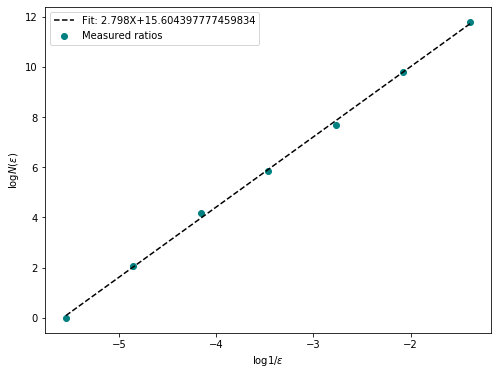

In [49]:
fig, ax = plt.subplots(figsize = (8,6))
ax.scatter(xs, ys, c = "teal", label = "Measured ratios")
ax.set_ylabel("$\log N(\epsilon)$")
ax.set_xlabel("$\log 1/ \epsilon$")
fitted_y_vals = np.polyval(coeffs, xs)
ax.plot(xs, fitted_y_vals, "k--", label = f"Fit: {np.round(coeffs[0],3)}X+{coeffs[1]}")
ax.legend();

We see that our fractional dimension is measured to be 2.79. That is not three at all.  We can try to sample more from the space we have to see if that will increase our accuracy.

scales: [  2   3   4   5   7   9  11  15  19  25  33  42  55  71  92 118 153 198
 256]
coefficient (fractal dimension) = 2.9073997373216005


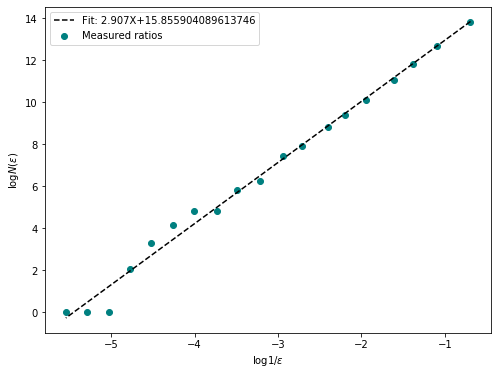

In [50]:
scales = np.logspace(largest_exponent, 1, num = 20, base = 2).astype(np.int32)
scales = np.unique(scales)
print(f"scales: {scales}")
Ns = []
for s in scales:
    bin_edges = [np.arange(0,i,s) for i in box.shape]
    H, edges = np.histogramdd(pixels, bins = bin_edges)
    Ns.append(np.sum(H>0))
    
xs = np.log(1/scales)
ys = np.log(Ns)
coeffs= np.polyfit(xs,ys, 1)
print(f"coefficient (fractal dimension) = {np.abs(coeffs[0])}")

fig, ax = plt.subplots(figsize = (8,6))
ax.scatter(xs, ys, c = "teal", label = "Measured ratios")
ax.set_ylabel("$\log N(\epsilon)$")
ax.set_xlabel("$\log 1/ \epsilon$")
fitted_y_vals = np.polyval(coeffs, xs)
ax.plot(xs, fitted_y_vals, "k--", label = f"Fit: {np.round(coeffs[0],3)}X+{coeffs[1]}")
ax.legend();

That is already a lot better than 2.79. There are two problems still left which, if solved, will increase the accuracy of our measurement. The first one has to do with how we are counting our boxes. Currently we put our shape on an arbitrary grid and count how many boxes are touched by the shape. What we should be doing is finding the _minimal set $N(s)$_ of boxes required to cover our shape. For this we need to offset our grid until we are touching the least amount of boxes at each scale. Play around with the visualization and you'll see why.

In [51]:
@interact
def show_scale(scale = widgets.IntSlider(min = 0,max=256, step=1,value =128, continuous_update = False)):
    @interact
    def show_offset(offset = widgets.IntSlider(min = 0,max=scale, step=1,value =1, continuous_update = False)):
        bin_edges = [np.arange(0, i, scale) for i in  box.shape]
        bin_edges = [np.hstack([0-offset,x + offset]) for x in bin_edges]
        fig,ax = plt.subplots()
        ax.set_xlim(0,np.min(box.shape))
        ax.set_ylim(0,np.min(box.shape))
        ax.imshow(box[box.shape[0]//2], cmap = "gray")
        ax.vlines(bin_edges[0], -offset, box.shape[0]+offset, "r")
        ax.hlines(bin_edges[1], -offset, box.shape[1]+offset, "r")

interactive(children=(IntSlider(value=128, continuous_update=False, description='scale', max=256), Output()), …

To find the minimal number of boxes to cover our shape at a specific scale, we can search over different offsets and pick the smallest value. Lets see what FD we get when we do that.

[  2   3   4   5   7   9  11  15  19  25  33  42  55  71  92 118 153 198
 256]
FD whithout offset:  : 2.9073997373216005
FD when smallest Ns chosen : 2.9372670027531607


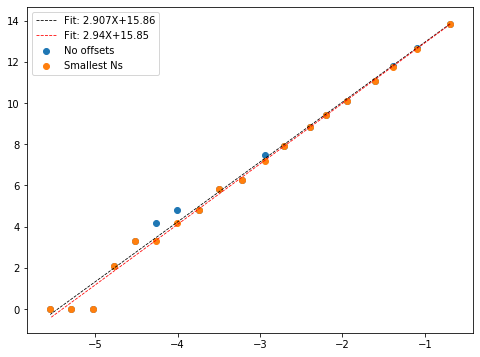

In [52]:
scales = np.logspace(largest_exponent, 1, num = 20, base = 2).astype(np.int32)
scales = np.unique(scales)
print(scales)
Ns = []
for scale in scales:
    touched = []
    offsets = np.linspace(0,scale, 10)
    for offset in offsets:
        bin_edges = [np.arange(0, i, scale) for i in  box.shape]
        bin_edges = [np.hstack([0-offset,x + offset]) for x in bin_edges]
        H1, e = np.histogramdd(pixels, bins = bin_edges)
        touched.append(np.sum(H1>0))
    Ns.append(touched)
        
Ns = np.array(Ns)

coeffs_max = np.polyfit(np.log(1/scales), np.log(Ns[:,0]), 1)
coeffs_min = np.polyfit(np.log(1/scales), np.log(Ns.min(axis = 1)), 1)

print(f"FD whithout offset:  : {np.abs(coeffs_max[0])}")
print(f"FD when smallest Ns chosen : {np.abs(coeffs_min[0])}")

fig,ax = plt.subplots(figsize = (8,6))
ax.scatter(np.log(1/scales), np.log(Ns[:,0]), label = "No offsets")
ax.scatter(np.log(1/scales), np.log(Ns.min(axis=1)), label = "Smallest Ns")
fitted_y_vals_no_offset = np.polyval(coeffs_max, np.log(1/scales))
ax.plot(np.log(1/scales), fitted_y_vals_no_offset, "k--", lw = 0.8, 
        label = f"Fit: {np.round(coeffs_max[0],3)}X+{np.round(coeffs_max[1],2)}")
fitted_y_vals_min = np.polyval(coeffs_min, np.log(1/scales))
ax.plot(np.log(1/scales), fitted_y_vals_min, "r--", lw = 0.8,
       label = f"Fit: {np.round(coeffs_min[0],2)}X+{np.round(coeffs_min[1],2)}");
ax.legend();

We are going in the right direction. In the above graph you see that at the largest scales measured, the number of boxes touched does not change. This influenced the results. If we were to keep only the smallest scales where the amount of boxes touched does not change, we should get a more accurate value:

In [53]:
Ns_min = Ns.min(axis = 1)

In [54]:
s  = np.array([np.min(scales[Ns_min == x]) for x in np.unique(Ns_min)])

In [55]:
coeffs = np.polyfit(np.log(1/s), np.log(np.unique(Ns_min)),1)
print(f"FD: {coeffs[0]}")

FD: 2.999442393569028


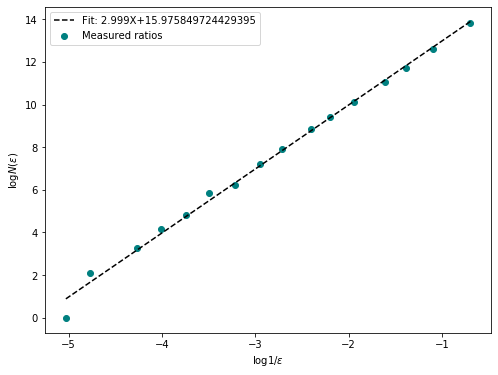

In [56]:
fig, ax = plt.subplots(figsize = (8,6))
ax.scatter(np.log(1/s), np.log(np.unique(Ns_min)), c = "teal", label = "Measured ratios")
ax.set_ylabel("$\log N(\epsilon)$")
ax.set_xlabel("$\log 1/ \epsilon$")
fitted_y_vals = np.polyval(coeffs, np.log(1/s))
ax.plot(np.log(1/s), fitted_y_vals, "k--", label = f"Fit: {np.round(coeffs[0],3)}X+{coeffs[1]}")
ax.legend();

Perfect! Now we can build a function and start testing some more interesting data than just a cube.

In [106]:
def fractal_dimension(array, max_box_size = None, min_box_size = 1, n_samples = 10, n_offsets = 0, plot = False):
    """Calculates the fractal dimension of a 3D numpy array.
    
    Args:
        array (np.ndarray): The array to calculate the fractal dimension of.
        max_box_size (int): The largest box size, given as the power of 2 so that
                            2**max_box_size gives the sidelength of the largest box.                     
        min_box_size (int): The smallest box size, given as the power of 2 so that
                            2**min_box_size gives the sidelength of the smallest box.
                            Default value 1.
        n_samples (int): number of scales to measure over.
        n_offsets (int): number of offsets to search over to find the smallest set N(s) to
                       cover  all voxels>0.
                            
        
    """
    #determine the scales to measure on
    if max_box_size == None:
        #default max size is the largest power of 2 that fits in the smallest dimension of the array:
        max_box_size = int(np.floor(np.log2(np.min(array.shape))))
    scales = np.floor(np.logspace(max_box_size,min_box_size, num = n_samples, base =2 ))
    scales = np.unique(scales) #remove duplicates that could occur as a result of the floor
    
    #get the locations of all non-zero pixels
    locs = np.where(array > 0)
    voxels = np.array([(x,y,z) for x,y,z in zip(*locs)])
    
    #count the minimum amount of boxes touched
    Ns = []
    #loop over all scales
    for scale in scales:
        touched = []
        if n_offsets == 0:
            offsets = [0]
        else:
            offsets = np.linspace(0, scale, n_offsets)
        #search over all offsets
        for offset in offsets:
            bin_edges = [np.arange(0, i, scale) for i in array.shape]
            bin_edges = [np.hstack([0-offset,x + offset]) for x in bin_edges]
            H1, e = np.histogramdd(voxels, bins = bin_edges)
            touched.append(np.sum(H1>0))
        Ns.append(touched)
    Ns = np.array(Ns)
    
    #From all sets N found, keep the smallest one at each scale
    Ns = Ns.min(axis=1)
   
    
    
    #Only keep scales at which Ns changed
    scales  = np.array([np.min(scales[Ns == x]) for x in np.unique(Ns)])
    
    
    Ns = np.unique(Ns)
    Ns = Ns[Ns > 0]
    scales = scales[:len(Ns)]
    #perform fit
    coeffs = np.polyfit(np.log(1/scales), np.log(Ns),1)
    
    #make plot
    if plot:
        fig, ax = plt.subplots(figsize = (8,6))
        ax.scatter(np.log(1/scales), np.log(np.unique(Ns)), c = "teal", label = "Measured ratios")
        ax.set_ylabel("$\log N(\epsilon)$")
        ax.set_xlabel("$\log 1/ \epsilon$")
        fitted_y_vals = np.polyval(coeffs, np.log(1/scales))
        ax.plot(np.log(1/scales), fitted_y_vals, "k--", label = f"Fit: {np.round(coeffs[0],3)}X+{coeffs[1]}")
        ax.legend();
    return(coeffs[0])
    




First we test our function with the same cube and parameters as before, to see if it does indeed perform the same:

FD of a box: 2.999442393569028


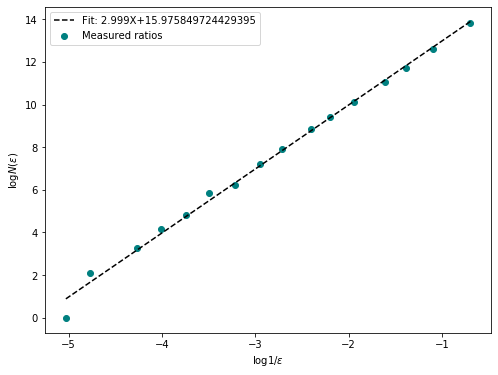

In [58]:
print(f"FD of a box: {fractal_dimension(box, n_samples=20, n_offsets = 10, plot = True)}")

Good! That is the same. Now lets measure other shapes that we know the dimensionality of. First a plane, and a line. These are 2 and 1 dimensional respectively.

FD of a plane: 2.291050997324321


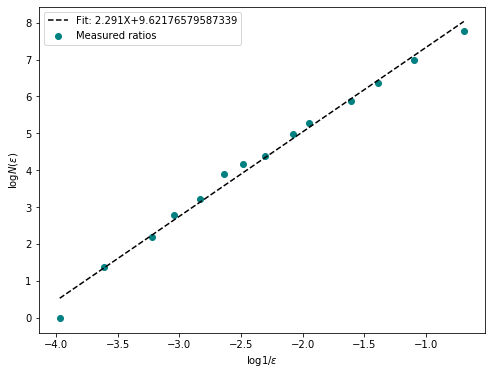

In [59]:
plane = np.zeros(shape = (100,100,100))
plane[50,:,:] = 1

print(f"FD of a plane: {fractal_dimension(plane, n_samples = 20, plot = True)}")

FD of a line: 1.095955394027351


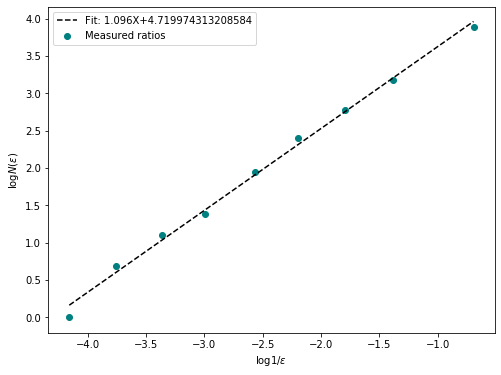

In [60]:
line = np.zeros(shape = (100,100,100))
line[50, 50, :] = 1

print(f"FD of a line: {fractal_dimension(line,plot = True)}")

FD of hollow box, measured without offsets: 2.918490228702892
FD of hollow box, measured with offsets: 2.95920059445599


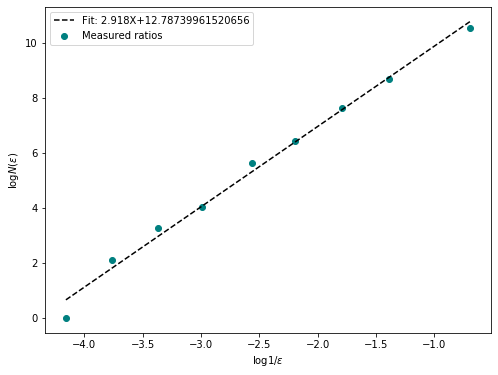

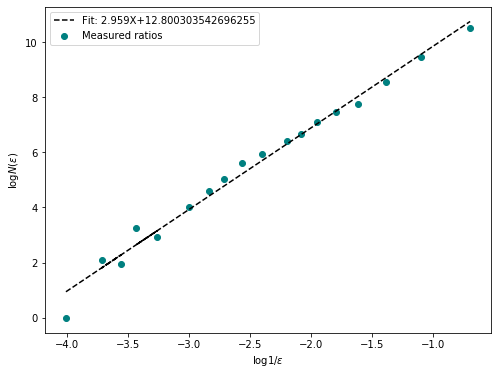

In [61]:
hollow_box = np.zeros(shape = (100,100,100))
hollow_box[10:90,10:90,10:90] = 1
hollow_box[20:80,20:80,20:80] = 0

print(f"FD of hollow box, measured without offsets: {fractal_dimension(hollow_box, plot = True)}")
print(f"FD of hollow box, measured with offsets: {fractal_dimension(hollow_box, n_samples = 25, n_offsets = 10, plot = True)}")

### An ultimate test - the menger sponge

A [menger sponge](https://en.wikipedia.org/wiki/Menger_sponge) is a fractal curve that is constructed in the following manner:

* Start with a cube, and divide it into 27 equal sub-cubes
* Remove all the sub-cubes in the center of a face
* Remove the sub-cube in teh center of the original cube
* Repeat this process _ad infinitum_ for all created sub-cubes and the sub-cubes created in the process.

The interesting property of a menger sponge $M_n$, like with many fractal shapes, is that in the $n^th$ iteration of its construction it is made up of $20^n$ sub cubes of sidelength $(1/3)^n$. The volume of the sponge is then $(20/27)^n$ while the surface is $2(20/9)^n + 4(8/9)^n$. This means that as n increases, the volume approaches zero while the surface increases, resulting in a shape of infinite surface area and no volume. 

The fractal dimension of the menger sponge is $\frac{\log 20}{\log 3} = 2.7268$


Lets first write code to  create an approximation of the menger sponge in a numpy array:

In [92]:
def menger_sponge(box, step = None):
    """recursively build a menger sponge.
    Args:
        box (int): if int, the outer dimensions of the sponge
        will be set to 3**box. Otherwise a 3d numpy array with sides
        that are a power of three may be passed.
    
    """
    if type(box) == int:
        box = np.ones([3**box for _ in range(3)])
    if not step:
        step = box.shape[0]
        #check if side is power of three:
        if not np.round(np.log(step) / np.log(3), 2).is_integer():
            print("side length not a power of three")
            return
    if step < 3:
        return box
    else:
        start_positions = np.arange(0, box.shape[0], step)
        s1 = int(step//3)
        s2 = step - s1
        
        for x in start_positions:
            for y in start_positions:
                for z in start_positions:
                    step += 1
                    sub_cube = box[x:x+step, y:y+step,z:z+step]
                    sub_cube[s1:s2,s1:s2,:] = 0
                    sub_cube[s1:s2,:,s1:s2] = 0
                    sub_cube[:,s1:s2,s1:s2] = 0
                    box[x:x+step, y:y+step,z:z+step] = sub_cube
                    
                    
        return menger_sponge(box, step = s1)

In [160]:
#create a sponge with sides 3**4
sponge = menger_sponge(4)

In [164]:
#place it in a larger context
side = sponge.shape[0]
padding = 25
sponge_space = np.zeros(shape = [2*padding+side for _ in range(3)])
sponge_space[padding:padding+side,padding:padding+side,padding:padding+side] = sponge

In [165]:
ipv.quickvolshow(sponge_space, level = [1,1,0.26], opacity = [0.2,0,0.2])

2.7042121715528324

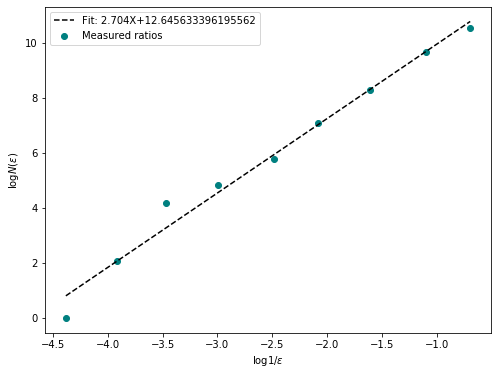

In [166]:
fractal_dimension(sponge_space, plot = True)

This is actually a surprisingly good measurement of the FD of a menger sponge, given that our constructed sponge is only an approximation of the theoretical shape.

## Conclusion
The function seems to be robust and functional. With shapes where the FD is not known the parameters should be tuned by looking at the diagnostic plot. For arrays where only very little of the space is taken up by the object picking a small max_box_size is a good idea.